# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score, roc_curve,auc
from imblearn.over_sampling import RandomOverSampler

In [2]:
# pip install imblearn

# Importing Dataset

In [3]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Encoding Categorical Values

In [5]:
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [6]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

In [7]:
ros = RandomOverSampler(random_state=42)
X_, y = ros.fit_resample(X,y)
X = pd.DataFrame(X_,columns=X.columns)

# Spliting into Train and Test Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

# Hyperparameter tuning using GridSearchCV

In [9]:
def tune_hyperparameters(model,X,y):
  param_grid = {
      'n_estimators' : [10,50,250,1000],
      'learning_rate' : [0.001,0.01,0.1,1.0,10]
  }
  grid_search = GridSearchCV(model,param_grid=param_grid)
  grid_search.fit(X,y)
  print("Best Params: ",grid_search.best_params_)
  return grid_search.best_params_

In [10]:
decision_tree_parameters = {'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.33334, 'max_leaf_nodes': 50, 'min_samples_leaf': 15, 'min_samples_split': 2, 'random_state': 0}

In [11]:
best_parameters_raw = tune_hyperparameters(AdaBoostClassifier(random_state=0,estimator=DecisionTreeClassifier(**decision_tree_parameters)),X_train,y_train)

Best Params:  {'learning_rate': 1.0, 'n_estimators': 250}


# AdaBoostClassifier

In [12]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("F1 Score: ",f1_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))


  fpr,tpr,thresholds = roc_curve(y_test,y_pred)
  plt.plot(fpr, tpr,color='green',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

Accuracy:  0.9797297297297297
Precision:  0.974937343358396
Recall:  0.9873096446700508
F1 Score:  0.9810844892812106
Confusion Matrix:
 [[336  10]
 [  5 389]]


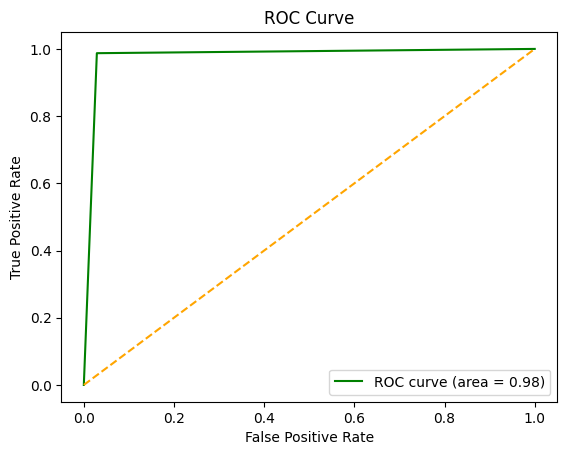

In [16]:
train_predict_evaluate(AdaBoostClassifier(random_state=0,estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X_train,y_train,X_test)

# K-Fold Cross Validation

In [14]:
def cross_validation(model,X,y):
    
    scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

    metrics = []
    metrics.append(np.mean(scores['test_accuracy']))
    metrics.append(np.mean(scores['test_precision']))
    metrics.append(np.mean(scores['test_recall']))
    metrics.append(np.mean(scores['test_f1']))

    print("Accuracy: ",metrics[0])
    print("Precision: ",metrics[1])
    print("Recall: ",metrics[2])
    print("F1 Score: ",metrics[3])

In [17]:
cross_validation(AdaBoostClassifier(random_state=0,estimator=DecisionTreeClassifier(**decision_tree_parameters),**best_parameters_raw),X,y)

Accuracy:  0.9858061443200763
Precision:  0.9748079741773467
Recall:  0.9975708502024292
F1 Score:  0.986000065782704
